# Import libraries

In [1]:
import pandas as pd
from ydata_profiling import ProfileReport  # One-stop-shop for initial profile of a dataset

import matplotlib
matplotlib.use('Agg')
#import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
import glob
import pandas as pd
#import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib inline


## EDA of Total Demand dataset
#### Modified: 2024-04-01

#### Set variables (*filepath, input file name, etc.*)

In [3]:
fpath = "..\\data\\all_raw_files"
fname_nsw_tdemand = "totaldemand_nsw.csv"
fname_qld_tdemand = "totaldemand_qld.csv"
fname_vic_tdemand = "totaldemand_vic.csv"
fname_sa_tdemand = "totaldemand_sa.csv"

#### Function for reading data

In [4]:
def read_data(datafile):
    df_data = pd.read_csv(datafile, sep = ',')
    #df_data.columns=[]
    return df_data

### Analysis

In [5]:
# Read file
df_nsw_tdemand = read_data(f'{fpath}\{fname_nsw_tdemand}')
df_qld_tdemand = read_data(f'{fpath}\{fname_qld_tdemand}')
df_vic_tdemand = read_data(f'{fpath}\{fname_vic_tdemand}')
df_sa_tdemand = read_data(f'{fpath}\{fname_sa_tdemand}')

#### Generate Data Profile Report (*using ydata_profiler*)

In [6]:
profile_nsw_tdemand = ProfileReport(df_nsw_tdemand, title="Total Demand NSW Data Profile")
profile_qld_tdemand = ProfileReport(df_qld_tdemand, title="Total Demand QLD Data Profile")
profile_vic_tdemand = ProfileReport(df_vic_tdemand, title="Total Demand VIC Data Profile")
profile_sa_tdemand = ProfileReport(df_sa_tdemand, title="Total Demand SA Data Profile")

#### Output Data Profile Report to Widgets

In [7]:
profile_nsw_tdemand.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
df_nsw_tdemand.head()

DATETIME  TOTALDEMAND REGIONID
0  1/1/2010 0:00      8038.00     NSW1
1  1/1/2010 0:30      7809.31     NSW1
2  1/1/2010 1:00      7483.69     NSW1
3  1/1/2010 1:30      7117.23     NSW1
4  1/1/2010 2:00      6812.03     NSW1

In [9]:
df_nsw_tdemand.describe()

TOTALDEMAND
count  196513.000000
mean     8113.145859
std      1299.532774
min      5074.630000
25%      7150.070000
50%      8053.230000
75%      8958.550000
max     14579.860000

In [10]:
df_nsw_tdemand.shape

(196513, 3)

## Import Temperature data

In [11]:
fpath = "..\\data\\all_raw_files"
fname_nsw_temp = "temperature_nsw.csv"
fname_qld_temp = "temperature_qld.csv"
fname_vic_temp = "temperature_vic.csv"
fname_sa_temp = "temperature_sa.csv"

In [12]:
# Read file
df_nsw_temp = read_data(f'{fpath}\{fname_nsw_temp}')
df_qld_temp = read_data(f'{fpath}\{fname_qld_temp}')
df_vic_temp = read_data(f'{fpath}\{fname_vic_temp}')
df_sa_temp = read_data(f'{fpath}\{fname_sa_temp}')

In [13]:
df_nsw_temp.head()

LOCATION       DATETIME  TEMPERATURE
0  Bankstown  1/1/2010 0:00         23.1
1  Bankstown  1/1/2010 0:01         23.1
2  Bankstown  1/1/2010 0:30         22.9
3  Bankstown  1/1/2010 0:50         22.7
4  Bankstown  1/1/2010 1:00         22.6

In [14]:
df_nsw_temp.describe()

TEMPERATURE
count  220326.000000
mean       17.418827
std         5.849763
min        -1.300000
25%        13.400000
50%        17.700000
75%        21.300000
max        44.700000

In [15]:
df_nsw_temp.shape

(220326, 3)

# Import PV Cell data

The PV data was obtained from the clean energy regulator

https://cleanenergyregulator.gov.au/markets/reports-and-data/small-scale-installation-postcode-data#postcode-data-files

According to the website, 
"the data represents all systems that have had certificates validly created against them. The data includes new installations, upgrades to existing systems and stand-alone (off-grid) systems. This data is not publicly available via the REC Registry and does not include systems that are pending registration or have been failed." (CER Website)

It is a collation of small generation units per postcode, not major installations.

These files were downloaded in March 2024. The current years dataset is still available on the website but the historical data is currently unavailable. Each file is an excel sheet, holding one years data plus data for the previous year. The data is split per postocde. File sizes run at approximately 2740 records. 

The data provides number of installations and amount of power (KW) installed. The wattage is the data that is collected per postcode per month. Once all data is collected, it is accumulated as per state. The routine add_state compiles the state post codes based on information from https://post-code.net.au/. This adds the figures of each post code to htier respective state.

Each year is accumulated into one data frome, holding State, Year, Month, Wattage. This will be added to the main dataframe.

Only NSW data will be used from this file but other states can be taken later, as required.

In [16]:
def add_state(row):
    tester = row['Postcode'] 
    if tester < 800:
        val="ACT"
    elif tester < 1000:
        val = "NT"
    elif tester < 2600:
        val = "NSW"
    elif tester < 2619:
        val = "ACT"
    elif tester < 2900:
        val = "NSW"
    elif tester < 2921:
        val = "ACT"
    elif tester < 3000:
        val = "NSW"
    elif tester < 4000:
        val = "Victoria"
    elif tester < 5000:
        val = "Queensland"
    elif tester < 6000:
        val = "SA"
    elif tester < 6000:
        val = "WA"
    elif tester < 8000:
        val = "WA"
    elif tester < 9000:
        val = "Victoria"
    else: 
        val="Queensland"
    return val

In [17]:
import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

In [18]:
path = r'..\data\all_raw_files'
all_files = glob.glob(path + "/*all data.xlsx")
dfs =[]
#print(all_files)

for i, f in enumerate(all_files):
    # Some excel files have changes sheet name
    if i < 14 :
        sheet_name= "SGU-Solar"
        header_size = 2
    elif i < 19:
        sheet_name= "SGU - Solar"
        header_size = 2
    else:
        sheet_name= "SGU-Solar"
        header_size = 3
    
    filename = os.path.basename(f)
    #print(filename)
    #print(i)
    df = pd.read_excel(f, header=header_size, usecols="A, AC, AE, AG, AI, AK, AM, AO, AQ, AS, AU,AW,AY")
    df.columns = ['Postcode', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
    df["Postcode"] = df["Postcode"].astype("int")
    df['State'] = df.apply(add_state, axis=1)
    
    df = df.groupby('State').sum().reset_index()
    df["Year"] = i + 2003
    df.drop('Postcode', axis=1, inplace=True)
    
    dfs.append(df)
    

df_item = pd.concat(dfs, ignore_index=True)
pv_install = pd.melt(df_item, id_vars=['State','Year'], value_vars=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
pv_install.columns = ['State', 'Year', 'Month', 'KW']
pv_install = pv_install[['State', 'Year', 'Month', 'KW']]


In [19]:
pv_install

State  Year Month         KW
0            ACT  2003     1      0.000
1            NSW  2003     1      9.450
2             NT  2003     1      0.000
3     Queensland  2003     1     11.290
4             SA  2003     1     36.055
...          ...   ...   ...        ...
1675          NT  2022    12    646.995
1676  Queensland  2022    12  47769.052
1677          SA  2022    12  17896.838
1678    Victoria  2022    12  15864.906
1679          WA  2022    12  21079.907

[1680 rows x 4 columns]

In [20]:
pv = pv_install[pv_install.State == "NSW"] 

pv

State  Year Month          KW
1      NSW  2003     1       9.450
8      NSW  2004     1      10.540
15     NSW  2005     1      16.665
22     NSW  2006     1       3.842
29     NSW  2007     1      23.265
...    ...   ...   ...         ...
1646   NSW  2018    12   50065.287
1653   NSW  2019    12   72877.365
1660   NSW  2020    12  105575.627
1667   NSW  2021    12   98467.488
1674   NSW  2022    12   57800.462

[240 rows x 4 columns]

In [21]:
pv = pv.groupby(['Year','Month'])["KW"].sum().reset_index()
pv['Date_ins'] = pd.to_datetime(dict(year=pv.Year, month=pv.Month, day=1))
pv = pv.sort_values(by=["Date_ins"])
pv["Cumulative"] = pv["KW"].cumsum()
pv

Year Month         KW   Date_ins   Cumulative
0    2003     1      9.450 2003-01-01        9.450
4    2003     2      6.300 2003-02-01       15.750
5    2003     3     13.456 2003-03-01       29.206
6    2003     4      4.190 2003-04-01       33.396
7    2003     5      2.100 2003-05-01       35.496
..    ...   ...        ...        ...          ...
238  2022     8  82520.975 2022-08-01  4782568.490
239  2022     9  70770.952 2022-09-01  4853339.442
229  2022    10  65520.720 2022-10-01  4918860.162
230  2022    11  86413.494 2022-11-01  5005273.656
231  2022    12  57800.462 2022-12-01  5063074.118

[240 rows x 5 columns]

# Australian population

The population data was found on the ABS website. The data sheet is split per state and per gender. 
https://www.abs.gov.au/statistics/people/population/national-state-and-territory-population/sep-2023/310104.xlsx is the link

The file name was changed to State Populations for the purpose of this project.

The datasheet 'Data1' contains population data per state from June 1981 to September 2023. The data is quarterly, so missing monthly data will be extrapolated from the data. The first fields are split by staet/gender but fields T to AA hold population per state data. This will be used in this project. 

The information is in a grid with each state in its own column. This is changed below to hold information by State, Year, Month.

This will allow the data to be merged with the master data, based on State/Year/Month.

The graph below shows a constant increase in the populations of all states over the last 40 years. There is a flattening of the graph in 2020, 2021 which correlates with the population stagnation during Covid.

Only NSW data will be used from this file but other states can be taken later, as required.


In [22]:
filename = r'..\data\all_raw_files\State populations.xlsx'
df = pd.read_excel(filename, header=10, sheet_name='Data1', usecols="A, T:AA")
df.columns= ['Date', 'NSW', 'Victoria', 'Queensland', 'SA', 'WA', 'Tasmania', 'NT','ACT']
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df.drop('Date', axis=1, inplace=True)

population = pd.melt(df, id_vars=['Year','Month'], value_vars=['NSW', 'Victoria', 'Queensland', 'SA', 'WA', 'Tasmania', 'NT','ACT'])
population.columns = ['Year', 'Month', 'State', 'Population']
population = population[population.State == "NSW"]

In [23]:
population

Year  Month State  Population
0    1981      9   NSW     5249455
1    1981     12   NSW     5266894
2    1982      3   NSW     5286119
3    1982      6   NSW     5303580
4    1982      9   NSW     5315846
..    ...    ...   ...         ...
163  2022      6   NSW     8166704
164  2022      9   NSW     8208445
165  2022     12   NSW     8246078
166  2023      3   NSW     8298017
167  2023      6   NSW     8339347

[168 rows x 4 columns]

The data in this file is quarterly. In order to match the data from other files (monthly), we will interpolate values between the months given.

In [24]:
# Loop through population
import math
population_rows = len(population)

for x in range(population_rows - 1):
    # Find difference between next record and this one.
    lower_val = population.iloc[x,0] * 12 + population.iloc[x,1]
    lower_pop = population.iloc[x,3]
    upper_val = population.iloc[x+1,0] * 12 + population.iloc[x+1,1]
    upper_pop = population.iloc[x+1,3]
    if upper_val-lower_val < 2:
        continue
    for y in range(upper_val-lower_val):
        if y == 0:
            continue
        
        new_pop = int(((upper_pop-lower_pop)/(upper_val-lower_val)) * y)
        a = lower_val + y
        year =  math.floor(a/12)
        month = (a % 12).astype(int)
        # Add to dataframe.
        population.loc[len(population.index)] = [year, month,'NSW', lower_pop + new_pop]
        #print(year, month, lower_pop + new_pop)

# For each value in difference, add new record to end with Year, Month and population
population = population.sort_values(by=["Year", 'Month']).reset_index(drop=True)
population

Year  Month State  Population
0    1981      9   NSW     5249455
1    1981     10   NSW     5255268
2    1981     11   NSW     5261081
3    1981     12   NSW     5266894
4    1982      1   NSW     5273302
..    ...    ...   ...         ...
497  2023      2   NSW     8280704
498  2023      3   NSW     8298017
499  2023      4   NSW     8311793
500  2023      5   NSW     8325570
501  2023      6   NSW     8339347

[502 rows x 4 columns]

State
NSW    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Population, dtype: object

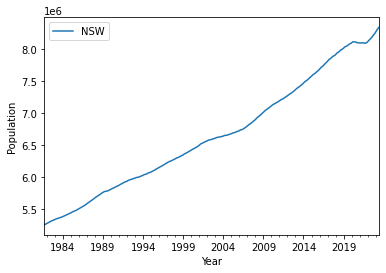

In [25]:
population['Date'] = pd.to_datetime(dict(year=population.Year, month=population.Month, day=1))

pop = population[['State', 'Date', 'Population']]
pop.set_index("Date", inplace=True)
pop.groupby("State")["Population"].plot(legend=True, xlabel="Year", ylabel="Population")



# GDP Data

In [26]:
fpath = "..\\data\\all_raw_files"
fname_aus_gsp = "GDP_Annual_Gross_State_Product_All_States.xlsx"
colnames = ['date', 'nsw_cvm', 'vic_cvm', 'qld_cvm', 'sa_cvm', 'wa_cvm', 'tas_cvm', 'nt_cvm', 'act_cvm', 'aus_cvm']

In [27]:
df_aus_gsp = pd.read_excel(f'{fpath}\{fname_aus_gsp}', sheet_name="Data1", skiprows=9, usecols="A:J", names=colnames)

In [28]:
df_aus_gsp['month'] = df_aus_gsp['date'].dt.month
df_aus_gsp['year'] = df_aus_gsp['date'].dt.year
df_aus_gsp

date  nsw_cvm  vic_cvm  qld_cvm  sa_cvm  wa_cvm  tas_cvm  nt_cvm  \
0  1990-06-01   335735   216165   141394   62973  113786    17721   11319   
1  1991-06-01   337278   210558   141579   62741  114505    17702   11607   
2  1992-06-01   337926   207543   146454   61664  118247    18138   11298   
3  1993-06-01   347414   217875   155635   63323  123722    18726   11314   
4  1994-06-01   360245   225250   163389   65059  132148    19124   11116   
5  1995-06-01   373474   232307   172822   65967  139504    19616   11655   
6  1996-06-01   387865   240327   178624   68639  147706    20368   12585   
7  1997-06-01   400572   250923   188157   71249  152776    20714   12849   
8  1998-06-01   415409   265717   195747   75166  161351    21489   13720   
9  1999-06-01   435452   282577   207327   76736  166252    21981   15284   
10 2000-06-01   454551   292216   216949   79433  173079    22107   15117   
11 2001-06-01   462443   297726   223422   81859  174727    21921   15727   
12 2002-06-01   471052   309125   237637   85909  186351    23077   17042   
13 2003-06-01   480849   317744   248524   88107  195996    23727   17235   
14 2004-06-01   494126   329621   265133   91029  210295    24945   17367   
15 2005-06-01   500740   343515   279279   92929  218121    25593   18162   
16 2006-06-01   506876   351392   293682   94203  228867    26614   19356   
17 2007-06-01   515768   361288   313527   95914  244161    27324   21750   
18 2008-06-01   526459   374193   328402  100398  256777    28480   21977   
19 2009-06-01   534051   381400   332831  103137  262862    29285   23843   
20 2010-06-01   542558   385336   339914  105358  278607    29543   23732   
21 2011-06-01   553440   396253   342795  107659  291562    30250   24414   
22 2012-06-01   566882   405822   362790  108761  315714    30849   25391   
23 2013-06-01   579398   409802   373159  109578  334784    30685   27120   
24 2014-06-01   593009   418902   380604  110004  354070    31155   27450   
25 2015-06-01   609333   430757   383818  111249  362109    31515   27816   
26 2016-06-01   631961   445714   392991  111865  365881    32085   28367   
27 2017-06-01   648206   462737   403260  114015  362200    32473   28782   
28 2018-06-01   662829   478591   419368  116570  370153    33667   29356   
29 2019-06-01   680189   493087   423285  117925  376299    34897   29020   
30 2020-06-01   673316   491651   418498  116749  380717    34931   30758   
31 2021-06-01   688693   490667   430157  122455  393223    36598   30253   
32 2022-06-01   706732   521709   454026  129272  404762    38171   31792   
33 2023-06-01   733087   535489   464580  134209  418775    38584   30123   

    act_cvm  aus_cvm  month  year  
0     15577   925958      6  1990  
1     15960   922422      6  1991  
2     16026   926367      6  1992  
3     16639   963840      6  1993  
4     17377  1002198      6  1994  
5     18027  1041115      6  1995  
6     18049  1081343      6  1996  
7     18797  1123658      6  1997  
8     19548  1176057      6  1998  
9     20692  1235185      6  1999  
10    21222  1283623      6  2000  
11    22320  1309618      6  2001  
12    23092  1361736      6  2002  
13    24136  1403823      6  2003  
14    24855  1463125      6  2004  
15    25665  1509274      6  2005  
16    26309  1550859      6  2006  
17    27893  1609379      6  2007  
18    29174  1667095      6  2008  
19    29966  1698646      6  2009  
20    31273  1736467      6  2010  
21    32182  1778298      6  2011  
22    33542  1847979      6  2012  
23    34647  1896141      6  2013  
24    34727  1945581      6  2014  
25    35714  1988419      6  2015  
26    37400  2043680      6  2016  
27    38912  2091067      6  2017  
28    40505  2151841      6  2018  
29    42197  2198775      6  2019  
30    43759  2191416      6  2020  
31    45467  2237695      6  2021  
32    46757  2333221      6  2022  
33    48767  2403614      6  2023

In [29]:
profile_aus_gsp = ProfileReport(df_aus_gsp, title="GSP Data Profile")

In [30]:
profile_aus_gsp

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

 Get NSW data and add month year and set values = gdp / 12

In [31]:
# New dataframe with a monthly gdp = current value/12 (add 12 months)
value_arr = []
month_arr = []
year_arr = []

for x in range(len(df_aus_gsp)):
    value = df_aus_gsp.iloc[x,1]
    month = df_aus_gsp.iloc[x,10]
    year = df_aus_gsp.iloc[x,11]
    
    for x in range(12):
        month_to_use = (month + x) %  12
        month_to_use = 12 if month_to_use ==0 else month_to_use
        year_to_use = year if (month+x)<13 else year+1
        
        value_arr.append(value/12)
        month_arr.append(month_to_use)
        year_arr.append(year_to_use)

        
data = {'Year' : year_arr, 'Month' : month_arr, 'GSP' : value_arr}
df_gsp = pd.DataFrame(data)
df_gsp.head(20)

Year  Month           GSP
0   1990      6  27977.916667
1   1990      7  27977.916667
2   1990      8  27977.916667
3   1990      9  27977.916667
4   1990     10  27977.916667
5   1990     11  27977.916667
6   1990     12  27977.916667
7   1991      1  27977.916667
8   1991      2  27977.916667
9   1991      3  27977.916667
10  1991      4  27977.916667
11  1991      5  27977.916667
12  1991      6  28106.500000
13  1991      7  28106.500000
14  1991      8  28106.500000
15  1991      9  28106.500000
16  1991     10  28106.500000
17  1991     11  28106.500000
18  1991     12  28106.500000
19  1992      1  28106.500000

# Merge information for NSW

## First Demand and Temperature

In [32]:
main_df = pd.merge(df_nsw_temp, df_nsw_tdemand, on = 'DATETIME', how='outer')

## Some analysis of temperature and demand for different intervals

In [33]:
main_df.describe()

TEMPERATURE    TOTALDEMAND
count  220326.000000  196526.000000
mean       17.418827    8113.119994
std         5.849763    1299.510032
min        -1.300000    5074.630000
25%        13.400000    7150.060000
50%        17.700000    8053.215000
75%        21.300000    8958.550000
max        44.700000   14579.860000

In [34]:
main_df = pd.merge(df_nsw_temp, df_nsw_tdemand, on = 'DATETIME')

In [35]:
main_df.head()

LOCATION       DATETIME  TEMPERATURE  TOTALDEMAND REGIONID
0  Bankstown  1/1/2010 0:00         23.1      8038.00     NSW1
1  Bankstown  1/1/2010 0:30         22.9      7809.31     NSW1
2  Bankstown  1/1/2010 1:00         22.6      7483.69     NSW1
3  Bankstown  1/1/2010 1:30         22.5      7117.23     NSW1
4  Bankstown  1/1/2010 2:00         22.5      6812.03     NSW1

In [36]:
main_df.shape

(195947, 5)

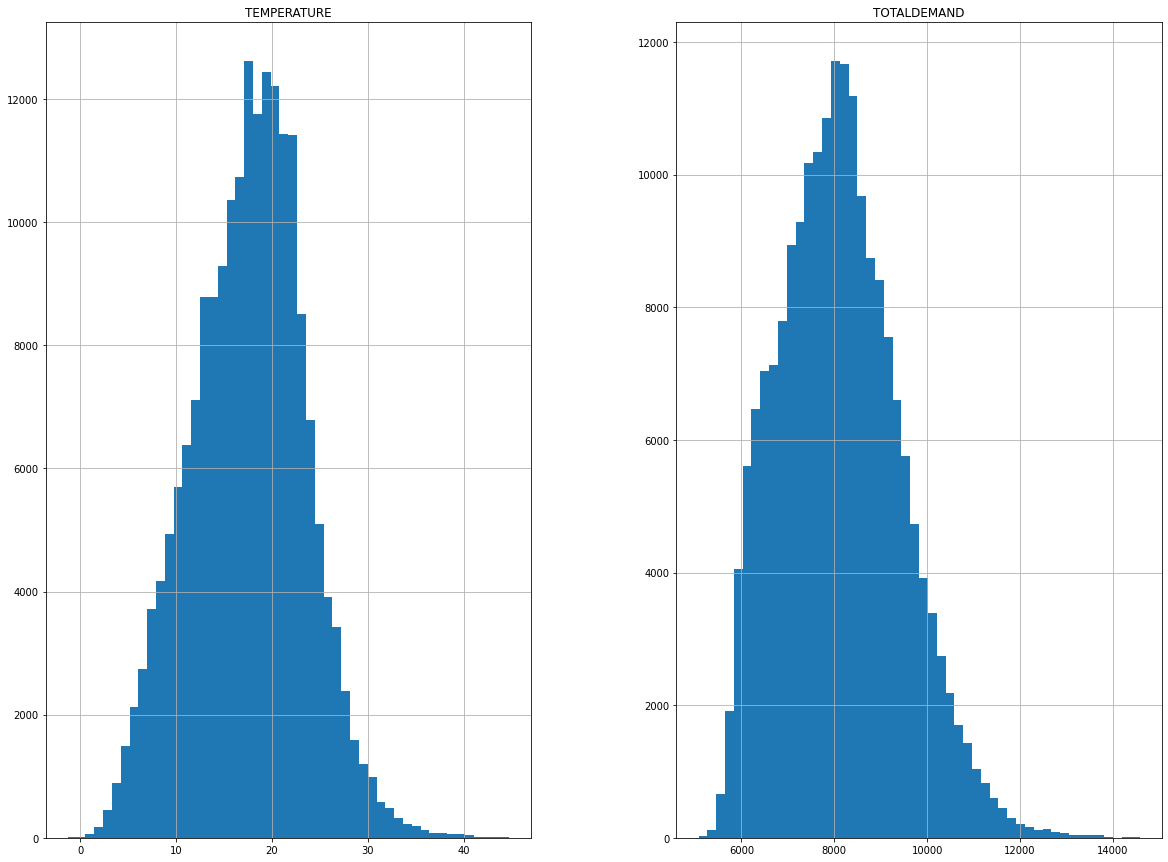

In [37]:
main_df.hist(bins=50, figsize=(20, 15))
plt.show()

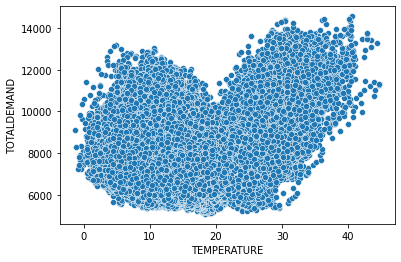

In [38]:
#sns.color_palette("Set2")
sns.scatterplot(data=main_df, x="TEMPERATURE", y="TOTALDEMAND",  palette="pastel")
#sns.color_palette("Set2")
plt.show()

In [39]:
main_df = main_df.dropna(how='all').dropna(how='all', axis=1)

In [40]:
main_df['DATETIME'] = pd.to_datetime(main_df['DATETIME'], format='mixed')

In [41]:
main_df.iloc[574,]

LOCATION                 Bankstown
DATETIME       2010-01-13 00:00:00
TEMPERATURE                   27.1
TOTALDEMAND                8915.77
REGIONID                      NSW1
Name: 574, dtype: object

In [42]:
main_df['day'] = main_df['DATETIME'].dt.day
main_df['month'] = main_df['DATETIME'].dt.month
main_df['year'] = main_df['DATETIME'].dt.year
main_df['hour'] = main_df['DATETIME'].dt.hour
main_df['date'] = main_df['DATETIME'].dt.date
main_df['weekday'] = main_df['DATETIME'].dt.weekday
main_df['day_name'] = main_df['DATETIME'].dt.day_name()

In [43]:
main_df

LOCATION            DATETIME  TEMPERATURE  TOTALDEMAND REGIONID  day  \
0       Bankstown 2010-01-01 00:00:00         23.1      8038.00     NSW1    1   
1       Bankstown 2010-01-01 00:30:00         22.9      7809.31     NSW1    1   
2       Bankstown 2010-01-01 01:00:00         22.6      7483.69     NSW1    1   
3       Bankstown 2010-01-01 01:30:00         22.5      7117.23     NSW1    1   
4       Bankstown 2010-01-01 02:00:00         22.5      6812.03     NSW1    1   
...           ...                 ...          ...          ...      ...  ...   
195942  Bankstown 2021-03-17 22:00:00         19.7      7419.77     NSW1   17   
195943  Bankstown 2021-03-17 22:30:00         19.5      7417.91     NSW1   17   
195944  Bankstown 2021-03-17 23:00:00         19.1      7287.32     NSW1   17   
195945  Bankstown 2021-03-17 23:30:00         18.8      7172.39     NSW1   17   
195946  Bankstown 2021-03-18 00:00:00         18.6      7094.51     NSW1   18   

        month  year  hour        date  weekday   day_name  
0           1  2010     0  2010-01-01        4     Friday  
1           1  2010     0  2010-01-01        4     Friday  
2           1  2010     1  2010-01-01        4     Friday  
3           1  2010     1  2010-01-01        4     Friday  
4           1  2010     2  2010-01-01        4     Friday  
...       ...   ...   ...         ...      ...        ...  
195942      3  2021    22  2021-03-17        2  Wednesday  
195943      3  2021    22  2021-03-17        2  Wednesday  
195944      3  2021    23  2021-03-17        2  Wednesday  
195945      3  2021    23  2021-03-17        2  Wednesday  
195946      3  2021     0  2021-03-18        3   Thursday  

[195947 rows x 12 columns]

In [44]:
main_df.groupby('date')[["TEMPERATURE", "TOTALDEMAND"]].mean()

TEMPERATURE  TOTALDEMAND
date                                
2010-01-01    25.185417  7801.352917
2010-01-02    24.461702  9557.546383
2010-01-03    18.737500  8560.798958
2010-01-04    19.191489  8499.952553
2010-01-05    15.912821  8025.070256
...                 ...          ...
2021-11-02    21.970833  7562.555417
2021-11-03    22.175000  7841.899792
2021-12-01    23.850000  8058.727083
2021-12-02    24.556250  8055.056250
2021-12-03    22.650000  7846.094375

[4092 rows x 2 columns]

<AxesSubplot:xlabel='DATETIME'>

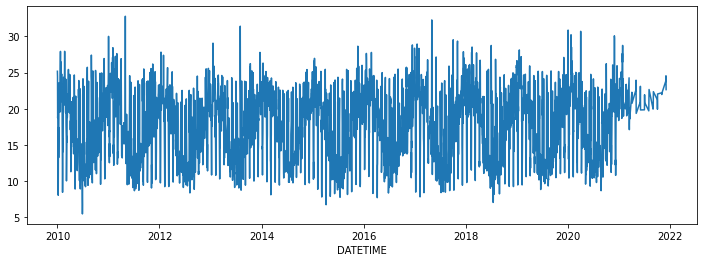

In [45]:
fig, axs = plt.subplots(figsize=(12, 4))

main_df.groupby([main_df["DATETIME"].dt.date])["TEMPERATURE"].mean().plot(
    kind='line', rot=0, ax=axs
)

<AxesSubplot:xlabel='DATETIME'>

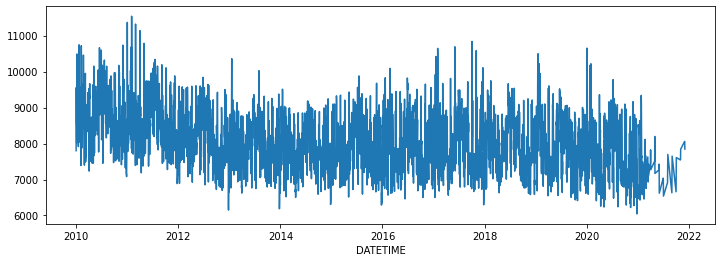

In [46]:
fig, axs = plt.subplots(figsize=(12, 4))

main_df.groupby([main_df["DATETIME"].dt.date])["TOTALDEMAND"].mean().plot(
    kind='line', rot=0, ax=axs
)

<AxesSubplot:xlabel='DATETIME'>

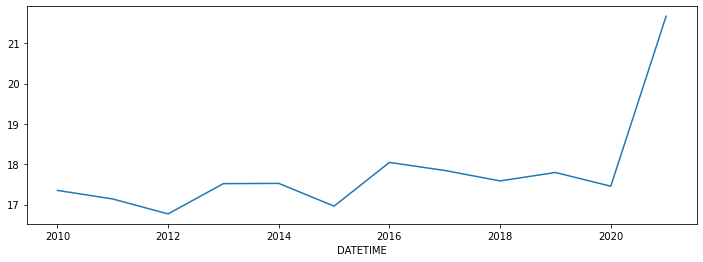

In [47]:
fig, axs = plt.subplots(figsize=(12, 4))

main_df.groupby([main_df["DATETIME"].dt.year])["TEMPERATURE"].mean().plot(
    kind='line', rot=0, ax=axs
)

<AxesSubplot:xlabel='DATETIME'>

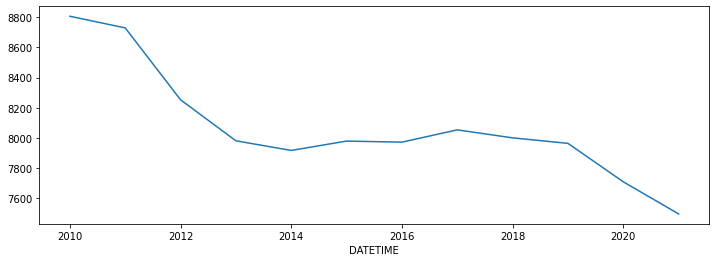

In [48]:
fig, axs = plt.subplots(figsize=(12, 4))

main_df.groupby([main_df["DATETIME"].dt.year])["TOTALDEMAND"].mean().plot(
    kind='line', rot=0, ax=axs
)

<AxesSubplot:xlabel='DATETIME'>

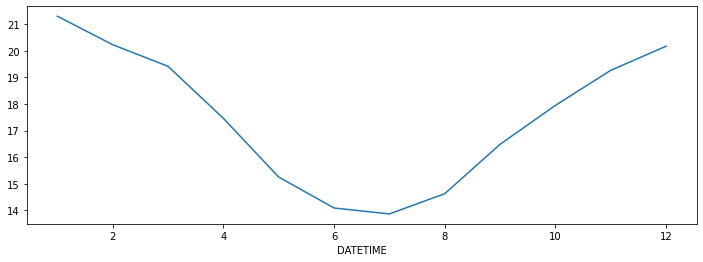

In [49]:
fig, axs = plt.subplots(figsize=(12, 4))

main_df.groupby([main_df["DATETIME"].dt.month])["TEMPERATURE"].mean().plot(
    kind='line', rot=0, ax=axs
)

<AxesSubplot:xlabel='DATETIME'>

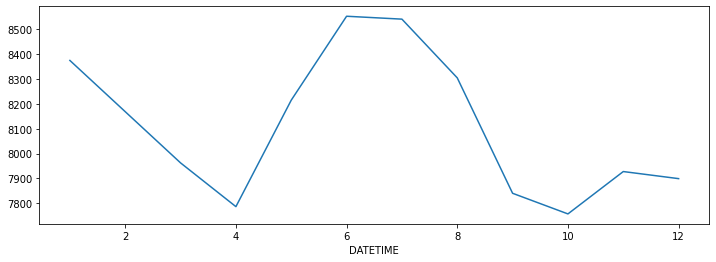

In [50]:
fig, axs = plt.subplots(figsize=(12, 4))

main_df.groupby([main_df["DATETIME"].dt.month])["TOTALDEMAND"].mean().plot(
    kind='line', rot=0, ax=axs
)

<AxesSubplot:xlabel='DATETIME'>

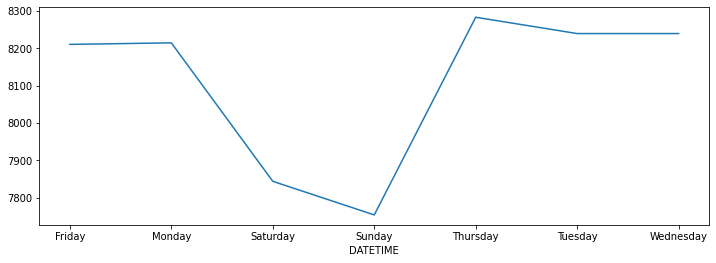

In [51]:
fig, axs = plt.subplots(figsize=(12, 4))

main_df.groupby([main_df["DATETIME"].dt.day_name()])["TOTALDEMAND"].mean().plot(
    kind='line', rot=0, ax=axs
)

In [52]:
main_df.groupby([main_df["DATETIME"].dt.year])[["TEMPERATURE", "TOTALDEMAND"]].mean()

TEMPERATURE  TOTALDEMAND
DATETIME                          
2010        17.350959  8806.634881
2011        17.137916  8729.258601
2012        16.767150  8253.115030
2013        17.518075  7981.460353
2014        17.524010  7917.697750
2015        16.960325  7979.624178
2016        18.044215  7972.542419
2017        17.844709  8053.839384
2018        17.585447  8001.012442
2019        17.794789  7964.534511
2020        17.454181  7709.863122
2021        21.669910  7497.118816

In [53]:
main_df.groupby([main_df["DATETIME"].dt.year])[["TEMPERATURE", "TOTALDEMAND"]].median()

TEMPERATURE  TOTALDEMAND
DATETIME                          
2010             17.4     8924.210
2011             17.1     8810.075
2012             17.3     8317.960
2013             17.7     8044.295
2014             18.1     7984.690
2015             17.3     7990.315
2016             18.3     7933.990
2017             18.3     7960.675
2018             18.0     7947.570
2019             18.2     7814.980
2020             17.6     7522.500
2021             21.2     7444.600

In [54]:
main_df.groupby([main_df["DATETIME"].dt.year])[["TEMPERATURE", "TOTALDEMAND"]].count()

TEMPERATURE  TOTALDEMAND
DATETIME                          
2010            17259        17259
2011            17502        17502
2012            17534        17534
2013            17516        17516
2014            17518        17518
2015            17520        17520
2016            17347        17347
2017            17520        17520
2018            17495        17495
2019            17520        17520
2020            17567        17567
2021             3649         3649

In [55]:
main_df.groupby([main_df["DATETIME"].dt.month])[["TEMPERATURE", "TOTALDEMAND"]].count()

TEMPERATURE  TOTALDEMAND
DATETIME                          
1               17410        17410
2               15810        15810
3               16707        16707
4               15940        15940
5               16457        16457
6               15939        15939
7               16305        16305
8               16492        16492
9               15974        15974
10              16474        16474
11              15952        15952
12              16487        16487

In [56]:
main_df.groupby([main_df["DATETIME"].dt.day])[["TEMPERATURE", "TOTALDEMAND"]].count()

TEMPERATURE  TOTALDEMAND
DATETIME                          
1                6915         6915
2                6903         6903
3                6863         6863
4                6324         6324
5                6297         6297
6                6335         6335
7                6326         6326
8                6325         6325
9                6324         6324
10               6338         6338
11               6336         6336
12               6336         6336
13               6473         6473
14               6471         6471
15               6456         6456
16               6417         6417
17               6402         6402
18               6375         6375
19               6400         6400
20               6401         6401
21               6388         6388
22               6418         6418
23               6420         6420
24               6424         6424
25               6425         6425
26               6421         6421
27               6425         6425
28               6430         6430
29               5993         5993
30               5842         5842
31               3744         3744

## Aggregate monthly information

In [57]:
result = main_df.groupby(['year','month']).agg({'TEMPERATURE': ['mean', 'min', 'max']
                                                , 'TOTALDEMAND' : ['mean', 'sum']}).droplevel(0, axis=1).reset_index()
result.columns=['Year', 'Month', "temp_mean" ,"temp_min","temp_max", "demand_mean", "demand_sum"]

In [58]:
result

Year  Month  temp_mean  temp_min  temp_max  demand_mean   demand_sum
0    2010      1  20.868008       1.6      41.1  8941.450389  13108166.27
1    2010      2  20.218907       3.2      35.4  8855.467677  11662650.93
2    2010      3  19.828286       6.3      34.7  8698.725127  12639247.61
3    2010      4  17.593856       6.5      29.9  8452.863411  11969254.59
4    2010      5  15.323485       3.1      28.4  8897.770510  12919562.78
..    ...    ...        ...       ...       ...          ...          ...
139  2021      8  21.104167      16.9      30.7  7368.353056   1061042.84
140  2021      9  20.999306      14.2      27.5  7229.393819   1041032.71
141  2021     10  21.084722      14.8      26.9  7209.823194   1038214.54
142  2021     11  22.118056      15.7      27.3  7649.492569   1101526.93
143  2021     12  23.685417      16.1      33.5  7986.625903   1150074.13

[144 rows x 7 columns]

In [59]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         144 non-null    int32  
 1   Month        144 non-null    int32  
 2   temp_mean    144 non-null    float64
 3   temp_min     144 non-null    float64
 4   temp_max     144 non-null    float64
 5   demand_mean  144 non-null    float64
 6   demand_sum   144 non-null    float64
dtypes: float64(5), int32(2)
memory usage: 6.9 KB


## Now add PV cells

In [60]:
pv_import = pv[['Month','Year','Cumulative']].reset_index(drop=True)
pv_import['Month'] = pv_import['Month'].astype(int)

result = result.merge(pv_import, on= ['Year', 'Month'], how='left')

## Add Population Data

In [61]:
population

Year  Month State  Population       Date
0    1981      9   NSW     5249455 1981-09-01
1    1981     10   NSW     5255268 1981-10-01
2    1981     11   NSW     5261081 1981-11-01
3    1981     12   NSW     5266894 1981-12-01
4    1982      1   NSW     5273302 1982-01-01
..    ...    ...   ...         ...        ...
497  2023      2   NSW     8280704 2023-02-01
498  2023      3   NSW     8298017 2023-03-01
499  2023      4   NSW     8311793 2023-04-01
500  2023      5   NSW     8325570 2023-05-01
501  2023      6   NSW     8339347 2023-06-01

[502 rows x 5 columns]

In [62]:
result = result.merge(population, on= ['Year', 'Month'], how='left')
result = result.drop('State', axis=1)

## Add GDP 

In [63]:
result = result.merge(df_gsp, on= ['Year', 'Month'], how='left')

## New dataframe and save

In [64]:
result =  result.drop('Date', axis=1)
result

Year  Month  temp_mean  temp_min  temp_max  demand_mean   demand_sum  \
0    2010      1  20.868008       1.6      41.1  8941.450389  13108166.27   
1    2010      2  20.218907       3.2      35.4  8855.467677  11662650.93   
2    2010      3  19.828286       6.3      34.7  8698.725127  12639247.61   
3    2010      4  17.593856       6.5      29.9  8452.863411  11969254.59   
4    2010      5  15.323485       3.1      28.4  8897.770510  12919562.78   
..    ...    ...        ...       ...       ...          ...          ...   
139  2021      8  21.104167      16.9      30.7  7368.353056   1061042.84   
140  2021      9  20.999306      14.2      27.5  7229.393819   1041032.71   
141  2021     10  21.084722      14.8      26.9  7209.823194   1038214.54   
142  2021     11  22.118056      15.7      27.3  7649.492569   1101526.93   
143  2021     12  23.685417      16.1      33.5  7986.625903   1150074.13   

      Cumulative  Population           GSP  
0      28278.392     7110454  44504.250000  
1      32153.986     7119405  44504.250000  
2      38195.588     7128356  44504.250000  
3      45142.723     7133668  44504.250000  
4      54370.332     7138980  44504.250000  
..           ...         ...           ...  
139  3954209.744     8091356  57391.083333  
140  4033918.477     8088503  57391.083333  
141  4112353.036     8092743  57391.083333  
142  4192992.282     8096983  57391.083333  
143  4291459.770     8101223  57391.083333  

[144 rows x 10 columns]

In [65]:
fpath = "..\\data\\all_raw_files"
fname_output = 'model_data.csv'
result.to_csv(f'{fpath}\{fname_output}')